<h1>MUCKING AROUND WITH POTUS DATA AND MACHINE LEARNING</h1>

<h2>IMPORT SOME LIBRARIES AND READ IN DATA</h2>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
##check out tutorial here:
##http://nbviewer.ipython.org/github/jvns/pandas-cookbook/blob/v0.1/cookbook/Chapter%201%20-%20Reading%20from%20a%20CSV.ipynb
df = pd.read_csv('../train.csv')
df1 = df.drop('Winner', 1)
df['Win_bin'] = (df['Winner'] == 'Barack Obama') ##new column: logical wrt winner
df.head()

,Total population,Median age,% BachelorsDeg or higher,Unemployment rate,Per capita income,Total households,Average household size,% Owner occupied housing,% Renter occupied housing,% Vacant housing,Median home value,Population growth,House hold growth,Per capita income growth,Winner,Win_bin
0,9278,37.9,12.6,21.3,13992,3802,2.42,51.9,16.6,31.6,63959,-0.69,-0.49,0.71,Barack Obama,True
1,18594,36.3,9.7,14.3,14622,6764,2.55,63.7,16.2,20.1,74330,-0.13,0.03,0.85,Barack Obama,True
2,662628,37.9,27.9,12.1,23909,267862,2.41,57.0,28.8,14.2,112687,-0.09,0.00,0.55,Barack Obama,True
3,21292,38.9,14.1,15.7,16829,8547,2.47,63.5,17.1,19.4,73643,-0.59,-0.43,0.57,Barack Obama,True
4,13252,34.5,15.0,15.8,13012,5222,2.47,53.7,20.7,25.6,56642,-1.16,-1.03,0.69,Barack Obama,True


<h2>VISUALIZE THE DATA (1ST AND 2ND PRINCIPAL COMPONENTS)</h2>

(1213, 2)


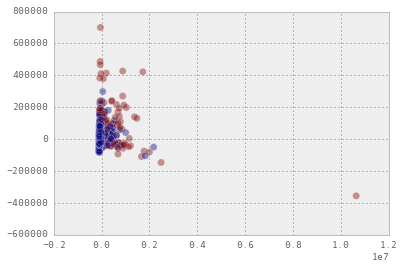

In [3]:
##using (parts of) andreas mueller's intro. to scikit-learn as a pseudo-template for analyzing 
##the POTUS data:
##https://github.com/amueller/sklearn_tutorial/blob/master/presentation.ipynb
from sklearn.decomposition import PCA #import principal component analysis
pca = PCA(n_components=2) #Instantiate the model & set parameters
pca.fit(df1); #Fit the model
df_pca = pca.transform(df1)#Apply the model. For embeddings / decompositions, this is transform.
print(df_pca.shape)
plt.scatter(df_pca[:, 0], df_pca[:, 1] , c = df['Win_bin'] , s = 50 , alpha=0.4);

<h2>SPLIT DATA INTO TRAINING AND TEST SETS</h2>

In [4]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df1, df['Win_bin'], random_state=0)
print("X_train shape: %s" % repr(X_train.shape))
print("y_train shape: %s" % repr(y_train.shape))
print("X_test shape: %s" % repr(X_test.shape))
print("y_test shape: %s" % repr(y_test.shape))

X_train shape: (909, 14)
y_train shape: (909,)
X_test shape: (304, 14)
y_test shape: (304,)


<h2>LET'S TRY A LINEAR SVM</h2>

In [5]:
from sklearn.svm import LinearSVC
svm = LinearSVC() # Instantiate the model.
svm.fit(X_train, y_train);#Fit the model.
svm.predict(X_train)# apply the model to the hold-out set
print(svm.score(X_train, y_train))
print(svm.score(X_test, y_test))

0.771177117712
0.815789473684


<h2>NOW LET'S TRY A SVM WITH A GAUSSIAN KERNEL</h2>

In [6]:
from sklearn.svm import SVC
svm1 = SVC(kernel='rbf')# Instantiate the model (SVM w/ Gaussian kernel)
svm1.fit(X_train, y_train);#Fit the model.
svm1.predict(X_train)# apply the model to the hold-out set
print(svm1.score(X_train, y_train))
print(svm1.score(X_test, y_test))

1.0
0.815789473684


<h2>IT'S TIME TO TRY A RANDOM FOREST</h2>

In [7]:
from sklearn.ensemble import RandomForestClassifier
#a random forest builds many randomized decision trees and averages their results.
rf = RandomForestClassifier() #Instantiate the model.
rf.fit(X_train , y_train); #fit the model
print(rf.score(X_train , y_train)) #evaluate the model on the training set
print( rf.score(X_test , y_test)) #evaluate the model on the hold-out set

0.985698569857
0.851973684211


<h2>NOW FOR CROSS-VALIDATION</h2>

In [8]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score( rf , X_train , y_train , cv = 5)
print( "the set of scores on the five CV sets are:  %s" % (str(scores)))
print( "the mean score is %s" % np.mean(scores))
print( "the SD of the scores in %s" % np.std(scores))

the set of scores on the five CV sets are:  [ 0.80327869  0.84065934  0.81318681  0.79005525  0.87292818]
the mean score is 0.824021653557
the SD of the scores in 0.0295636319691


Will more trees improve model performance?

In [9]:
rf2 = RandomForestClassifier(n_estimators=50)
scores = cross_val_score( rf2 , X_train , y_train , cv = 5)
print( "the set of scores on the five CV sets are:  %s" % (str(scores)))
print( "the mean score is %s" % np.mean(scores))
print( "the SD of the scores in %s" % np.std(scores))

the set of scores on the five CV sets are:  [ 0.81967213  0.81318681  0.81868132  0.79558011  0.86740331]
the mean score is 0.822904737686
the SD of the scores in 0.0238725101164


It doesn't really look like it.

<h2>LET'S NOW MUCK AROUND WITH TUNING HYPERPARAMETERS IN THE SVM CASE </h2>

In [30]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
#also see here: http://scikit-learn.org/stable/auto_examples/grid_search_digits.html
svm = LinearSVC() # Instantiate the model
tuned_parameters = {'C':10.**np.arange(-3,5)}
grid_search = GridSearchCV( svm , param_grid = tuned_parameters , cv = 3 ,verbose = 3 )
grid_search.fit(X_train, y_train);
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] C=0.001 .........................................................
[CV] ................................ C=0.001, score=0.796053 -   0.0s
[CV] C=0.001 .........................................................
[CV] ................................ C=0.001, score=0.772277 -   0.0s
[CV] C=0.001 .........................................................
[CV] ................................ C=0.001, score=0.807947 -   0.0s
[CV] C=0.01 ..........................................................
[CV] ................................. C=0.01, score=0.779605 -   0.0s
[CV] C=0.01 ..........................................................
[CV] ................................. C=0.01, score=0.795380 -   0.0s
[CV] C=0.01 ..........................................................
[CV] ................................. C=0.01, score=0.804636 -   0.0s
[CV] C=0.1 ...........................................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.1s finished



[CV] C=10000.0 .......................................................
[CV] .............................. C=10000.0, score=0.771523 -   0.0s
{'C': 0.01}
0.793179317932


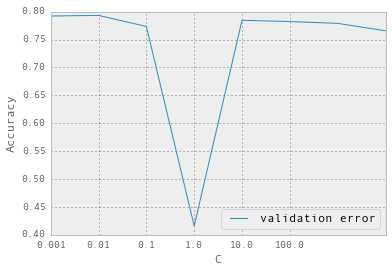

In [33]:
plt.plot([c.mean_validation_score for c in grid_search.grid_scores_], label="validation error")
plt.xticks(np.arange(6), tuned_parameters['C']); plt.xlabel("C"); plt.ylabel("Accuracy");plt.legend(loc='best');
#see this thread concerning mean_training_score:
#http://stackoverflow.com/questions/23389334/how-to-calculate-the-mean-training-score-using-gridsearchcv-in-scikit-learns

<h2> A SLIGHTLY DIFFERENT APPROACH </h2>

In [10]:
###another (slightly different) approach: from
###http://scikit-learn.org/stable/auto_examples/grid_search_digits.html
tuned_parameters = {'C':10*np.arange(1,4)}
scores = ['precision', 'recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV( svm, tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l2',
     random_state=None, tol=0.0001, verbose=0)
()
Grid scores on development set:
()
0.395 (+/-0.142) for {'C': 10}
0.305 (+/-0.103) for {'C': 20}
0.298 (+/-0.138) for {'C': 30}
()
Detailed classification report:
()
The model is trained on the full development set.
The scores are computed on the full evaluation set.
()
             precision    recall  f1-score   support

      False       0.82      1.00      0.90       248
       True       0.75      0.05      0.10        56

avg / total       0.81      0.82      0.75       304

()
# Tuning hyper-parameters for recall
()
Best parameters set found on development set:
()
LinearSVC(C=20, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l2',
     ran

/Users/hugobowne-anderson/anaconda/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<h2>NOW WE'RE GOING TO TRY A BUNCH OF SVMs (LINEAR, POLYNOMIAL & GAUSSIAN KERNELS) AND PERFORM
A GRID SEARCH OVER THE HYPERPARAMETERS (TUNING THEM), SELECTING FOR PRECISION</h2>

In [ ]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import svm, metrics, preprocessing
import csv
import time
# Set the parameters by cross-validation

start_time = time.time()

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10]},
                    {'kernel': ['linear'], 'C': [1, 10]},{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['poly'], 'degree': [2]},
                    {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['poly'], 'degree': [3]},
                    {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['poly'], 'degree': [4]}]


scores = ['precision'] # you can alter this by adding, for example, `recall'

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %s"
              % (mean_score, scores.std() / 2, params))
    print()
    
print(time.time()- start_time)